# YOLO Data Preparation Notebook
Authors: Cait Newport & Rachel Parkinson
Date: 2025-01-31

This is a notebook to help with data preparation for YOLO training.

It assumes you have a dataset in YOLO format.

## Environment Setup
This has been tested on a Mac (with M3 chip) and Windows (with CPU)

In [ ]:
# RUN COMMANDS IN THIS CELL FROM THE TERMINAL or with ! in front of the command in a cell

# You will get error messages if you try to install torch with newer python versions. Stick with Python 3.11

# For Mac:
# brew install python@3.11

# For Windows:
# Download Python 3.11 from https://www.python.org/downloads/
# Make sure to check "Add Python to PATH" during installation

# Create and activate a Python virtual environment
# For Mac:
# python3.11 -m venv yolo_training_enviro
# source yolo_training_enviro/bin/activate

# For Windows:
# python -m venv yolo_training_enviro
# yolo_training_enviro\Scripts\activate

# Install ipykernel if not already installed
!pip install ipykernel

# Register the kernel with Jupyter
!python -m ipykernel install --user --name=yolo_training_enviro --display-name="YOLO Training (Python 3.11)"

# In later stages you may get errors about 'import'. You may need to change your kernel to the one you just created.
# You can do this by clicking on the kernel in the top right of the notebook and selecting the kernel you want.
# Choose "YOLO Training (Python 3.11)" which you just made.

In [ ]:

# Verify the kernel is correct by running this cell:
import sys
print(sys.executable)  # This will show which Python interpreter you're using
# It should now show a path that includes your virtual environment (yolo_training_enviro)

In [ ]:
# Install PyTorch (run the correct command in the terminal)

# For Mac with M-series chip (M1/M2/M3):
# pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

# For Mac with Intel chip:
# pip3 install torch torchvision torchaudio

# For Windows:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Torch can be optimized for a MAC M3 chip. To check if it is, run this cell (Mac only):

In [ ]:
# Check PyTorch device configuration
import torch

print(f"PyTorch version: {torch.__version__}")

# For Mac:
print(f"MPS (Metal) available: {torch.backends.mps.is_available()}")
print(f"Current device: {torch.device('mps' if torch.backends.mps.is_available() else 'cpu')}")


Torch can be optimized for a Windows GPU. To check if it is, run this cell (Windows only):

In [6]:
# Check PyTorch device configuration
import torch

print(f"PyTorch version: {torch.__version__}")

# For Windows with GPU:
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"Current device: {torch.device('cuda')}")
else:
    print("No CUDA GPU available, using CPU")
    print(f"Current device: {torch.device('cpu')}")

# If you see that CUDA is not available on a Windows machine with a GPU, you might need to:
# 1. Install the NVIDIA CUDA Toolkit
# 2. Install the correct PyTorch version with CUDA support (using the command from the previous response)
# 3. Make sure you have updated NVIDIA drivers

PyTorch version: 2.6.0+cpu
CUDA available: False
No CUDA GPU available, using CPU
Current device: cpu


Note: You can still train YOLO on a CPU, but it will be slower.

In [ ]:
# Install Ultralytics which has the YOLO library.

# pip install ultralytics # (run this in the terminal)

## Data Preparation
You will need to have a dataset in YOLO format.

You can generate a dataset of labelled images using a tool like Label Studio: https://labelstud.io/ or Labelbox: https://app.labelbox.com

The folder structure should be:

In [ ]:
dataset/
  ├── images/
  │   ├── image1.jpg
  │   └── image2.jpg
  ├── labels/
  │   ├── image1.txt
  │   └── image2.txt
  └── classes.txt  # or data.yaml

A text file would have the classes listed in order. For example:


  bee_alive

  bee_dead

  feeder

A data.yaml file would have the classes listed in order. For example:


names:

  0: bee_alive

  1: bee_dead

  2: feeder 

In [1]:
# To see some of your images with annotations:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os


In [13]:

# Update these paths to match your directory structure
IMAGE_DIR = "../dataset/alive-dead-data/train/images"
LABEL_DIR = "../dataset/alive-dead-data/train/labels"
class_names = ["bee_alive", "bee_dead", "feeder"]  # Replace with your classes

# Choose a specific image to visualize
image_name = "img0834.png"  # Replace with your image name
label_name = image_name.replace('.png', '.txt') 

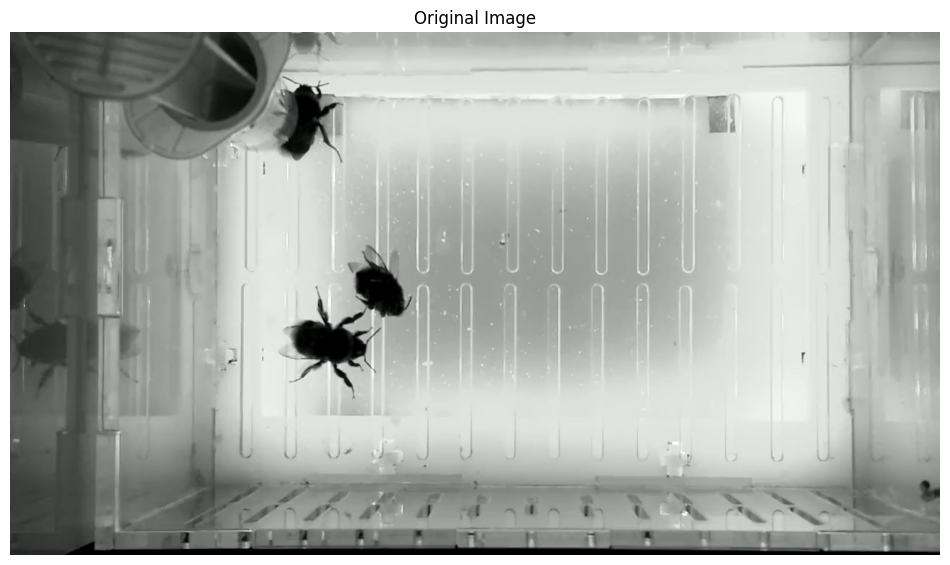

In [14]:
# Read image
image_path = os.path.join(IMAGE_DIR, image_name)
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show original image
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

Your labels data will either be formatted using class_id, x_center, y_center, width, height or using 4 corner points (x,y pairs) for rotated bounding boxes. 

This will depend how you have labelled your images and how you exported the data from your labelling tool. 

Either format works fine for YOLO automatically, however the subsequent code will need to be adjusted to match the format of your labels.

For the format using class_id, x_center, y_center, width, height:

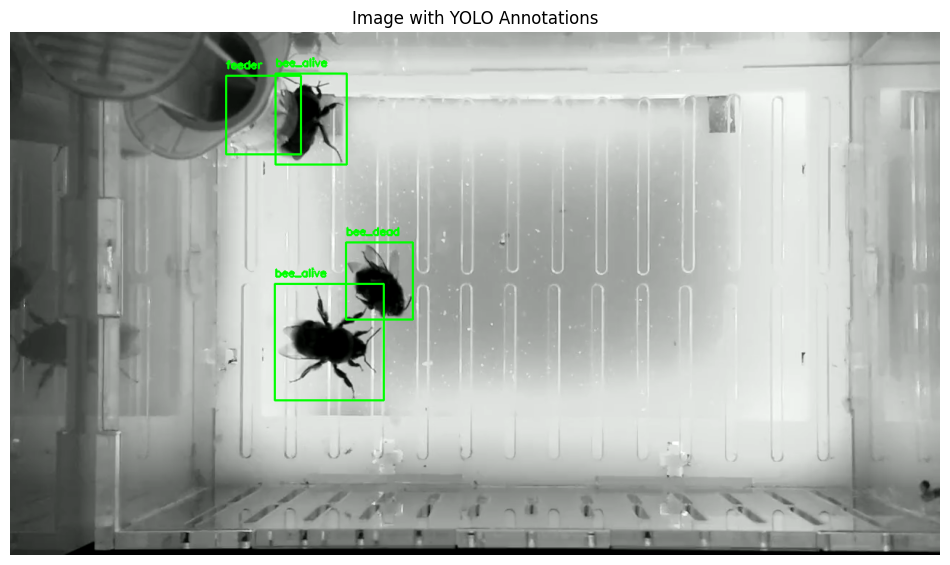

In [15]:
# Read annotations
label_path = os.path.join(LABEL_DIR, label_name)
boxes = []

with open(label_path, 'r') as f:
    for line in f.readlines():
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append([int(class_id), x_center, y_center, width, height])

# Convert and draw boxes
img_height, img_width = img.shape[:2]
img_with_boxes = img.copy()

for box in boxes:
    class_id, x_center, y_center, width, height = box
    
    # Convert normalized coordinates to pixel coordinates
    x = int((x_center - width/2) * img_width)
    y = int((y_center - height/2) * img_height)
    w = int(width * img_width)
    h = int(height * img_height)
    
    # Draw rectangle
    cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Add label
    label = class_names[int(class_id)] if class_names else str(int(class_id))
    cv2.putText(img_with_boxes, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display image with boxes
plt.figure(figsize=(12, 8))
plt.imshow(img_with_boxes)
plt.axis('off')
plt.title('Image with YOLO Annotations')
plt.show()

To View multiple samples:

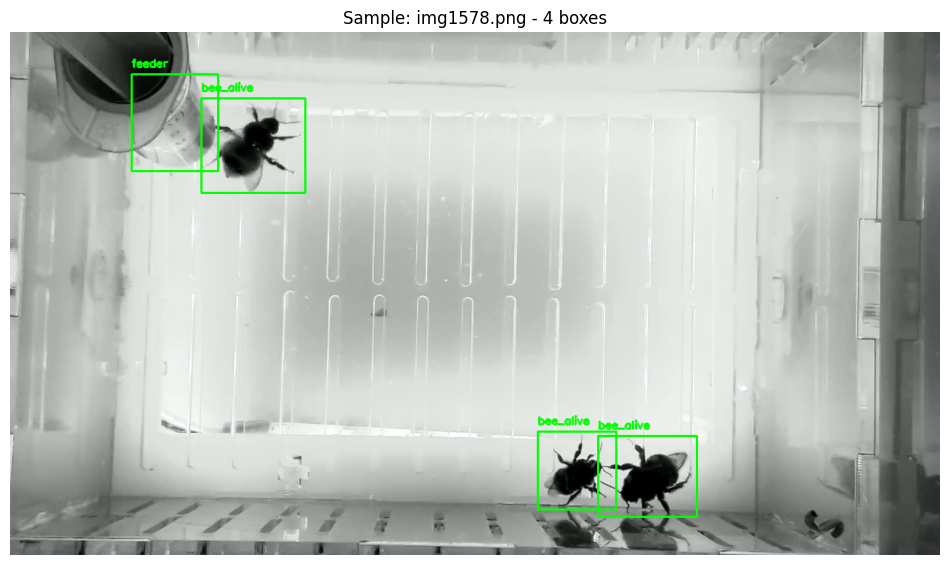

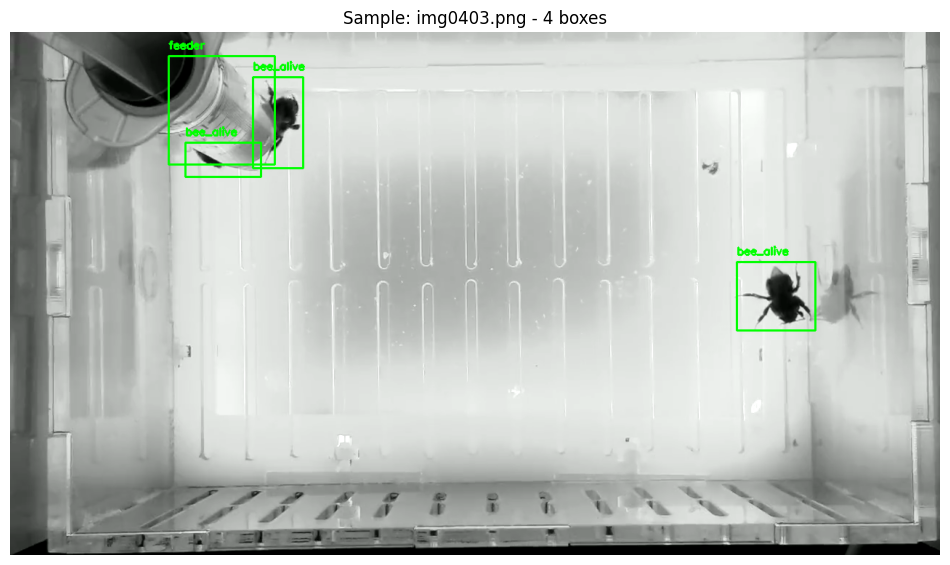

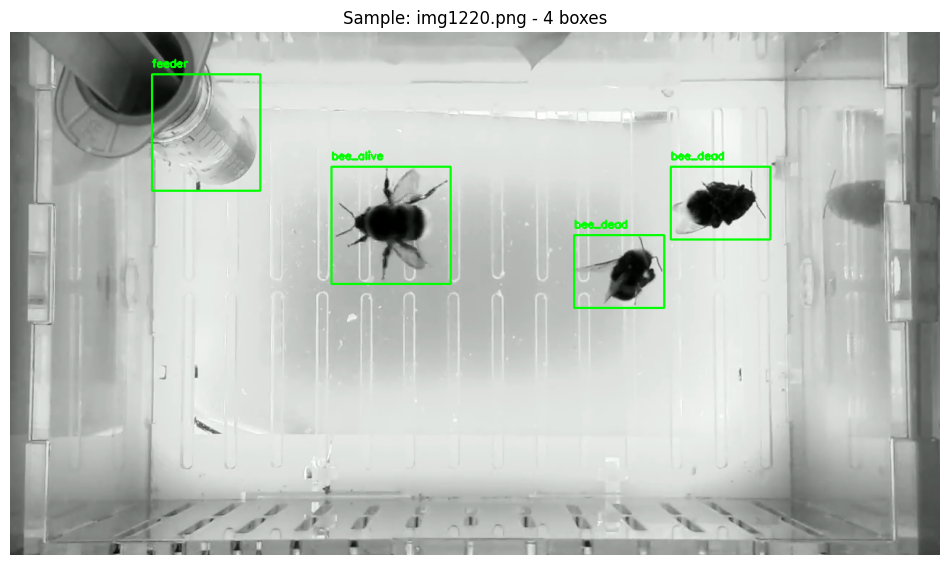

In [18]:
# Get list of image files
image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Select 3 random samples
num_samples = 3
samples = np.random.choice(image_files, num_samples)

# Process each sample
for image_name in samples:
    # Get corresponding label file name
    label_name = os.path.splitext(image_name)[0] + '.txt'
    
    # Read image
    image_path = os.path.join(IMAGE_DIR, image_name)
    img = cv2.imread(image_path)
    
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        continue
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Read annotations
    label_path = os.path.join(LABEL_DIR, label_name)
    boxes = []  # Reset boxes for each new image

    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                values = line.strip().split()
                class_id = int(float(values[0]))
                # Extract the 4 corner points (x,y pairs)
                # Extract YOLO format: center_x, center_y, width, height (all normalized)
                center_x = float(values[1])
                center_y = float(values[2])
                width = float(values[3])
                height = float(values[4])
                boxes.append([class_id, center_x, center_y, width, height])

        # Draw boxes
        img_height, img_width = img.shape[:2]

        for box in boxes:
            class_id, center_x, center_y, width, height = box
            
            # Convert normalized coordinates to pixel coordinates
            center_x_px = center_x * img_width
            center_y_px = center_y * img_height
            width_px = width * img_width
            height_px = height * img_height
            
            # Calculate top-left and bottom-right corners
            x1 = int(center_x_px - width_px / 2)
            y1 = int(center_y_px - height_px / 2)
            x2 = int(center_x_px + width_px / 2)
            y2 = int(center_y_px + height_px / 2)
            
            # Draw the bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
            
            # Add label at the top-left corner of the box
            label = class_names[int(class_id)] if class_names else str(int(class_id))
            cv2.putText(img, label, 
                        (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Display
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Sample: {image_name} - {len(boxes)} boxes')
        plt.show()

    except FileNotFoundError:
        print(f"Warning: No label file found for {image_name}")
        continue
    except Exception as e:
        print(f"Error processing {label_path}: {str(e)}")
        continue

When training a YOLO detector, we split our dataset into training and validation sets for a few key reasons:

The training set is used to actually teach the model, updating its weights and biases as it learns to detect objects. The validation set, on the other hand, serves as an independent test to check if the model is actually learning to generalize rather than just memorizing the training data.

This separation helps us detect overfitting - a situation where the model performs really well on the training data but fails on new, unseen images. If we see the model's performance improving on the training set but getting worse on the validation set, that's a clear sign of overfitting.
Think of it like studying for an exam - you want to learn the concepts (training) but also check your understanding on practice problems you haven't seen before (validation) to make sure you truly understand the material rather than just memorizing specific examples.
This split also helps with tuning hyperparameters like learning rate or batch size, as we can adjust these based on validation performance without contaminating our final test set.

Ideally, training and validation data will come from separate recordings (rather than separating images from a single video for training and validation). For the bee data, we used completely separate experiments for training and validation. 

** Below code was for separating the data automatically, however this was not used in the dead-alive-bees training **

In [9]:
import os
import shutil
import numpy as np
from pathlib import Path

def split_dataset(train_ratio=0.8, seed=42):
    """
    Split dataset into training and validation sets with YOLO folder structure.
    
    Args:
        train_ratio (float): Ratio of training data (default: 0.8)
        seed (int): Random seed for reproducibility (default: 42)
    """
    # Set random seed
    np.random.seed(seed)
    
    # Setup paths
    dataset_path = Path('../dataset')
    
    # Create YOLO-standard directory structure
    train_img_dir = dataset_path / 'train' / 'images'
    train_label_dir = dataset_path / 'train' / 'labels'
    val_img_dir = dataset_path / 'val' / 'images'
    val_label_dir = dataset_path / 'val' / 'labels'
    
    # Create directories
    for dir_path in [train_img_dir, train_label_dir, val_img_dir, val_label_dir]:
        dir_path.mkdir(parents=True, exist_ok=True)
    
    # Get list of image files
    image_files = [f for f in os.listdir(dataset_path / 'images') 
                  if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Randomly split indices
    num_files = len(image_files)
    num_train = int(num_files * train_ratio)
    indices = np.random.permutation(num_files)
    train_indices = indices[:num_train]
    val_indices = indices[num_train:]
    
    print("Splitting dataset...")
    print(f"Total images: {num_files}")
    print(f"Training images: {len(train_indices)}")
    print(f"Validation images: {len(val_indices)}")
    
    # Copy files to train/val directories
    for idx in train_indices:
        img_file = image_files[idx]
        label_file = os.path.splitext(img_file)[0] + '.txt'
        
        # Copy image
        shutil.copy2(
            dataset_path / 'images' / img_file,
            train_img_dir / img_file
        )
        
        # Copy label if it exists
        if os.path.exists(dataset_path / 'labels' / label_file):
            shutil.copy2(
                dataset_path / 'labels' / label_file,
                train_label_dir / label_file
            )
    
    for idx in val_indices:
        img_file = image_files[idx]
        label_file = os.path.splitext(img_file)[0] + '.txt'
        
        # Copy image
        shutil.copy2(
            dataset_path / 'images' / img_file,
            val_img_dir / img_file
        )
        
        # Copy label if it exists
        if os.path.exists(dataset_path / 'labels' / label_file):
            shutil.copy2(
                dataset_path / 'labels' / label_file,
                val_label_dir / label_file
            )
    
    print("\nDataset split complete!")
    print(f"Training images: {len(list(train_img_dir.glob('*')))} files")
    print(f"Training labels: {len(list(train_label_dir.glob('*')))} files")
    print(f"Validation images: {len(list(val_img_dir.glob('*')))} files")
    print(f"Validation labels: {len(list(val_label_dir.glob('*')))} files")

# Run the split
if __name__ == "__main__":
    split_dataset()

Splitting dataset...
Total images: 150
Training images: 120
Validation images: 30

Dataset split complete!
Training images: 120 files
Training labels: 120 files
Validation images: 30 files
Validation labels: 30 files


Check the image sizes in your training and validation folders

In [19]:
# Check image size

import os
from PIL import Image
import numpy as np

def check_image_sizes(image_dir):
    widths = []
    heights = []
    
    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"\nChecking {len(image_files)} images in {image_dir}")
    
    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        with Image.open(img_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)
    
    print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.0f}")
    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.0f}")
    
    # Show a few example sizes
    unique_sizes = set(zip(widths, heights))
    print(f"\nUnique image sizes found: {len(unique_sizes)}")
    for size in list(unique_sizes)[:5]:
        print(f"- {size[0]} x {size[1]}")

# Check both train and val directories
check_image_sizes("../dataset/alive-dead-data/train/images")
check_image_sizes("../dataset/alive-dead-data/val/images")


Checking 163 images in ../dataset/alive-dead-data/train/images
Width  - Min: 1280, Max: 1280, Mean: 1280
Height - Min: 720, Max: 720, Mean: 720

Unique image sizes found: 1
- 1280 x 720

Checking 50 images in ../dataset/alive-dead-data/val/images
Width  - Min: 1280, Max: 1280, Mean: 1280
Height - Min: 720, Max: 720, Mean: 720

Unique image sizes found: 1
- 1280 x 720


In [12]:
import os
from pathlib import Path

def print_directory_structure():
    base_dir = Path('../dataset')
    print("\nChecking directory structure:")
    print(f"\nContents of {base_dir}:")
    for item in base_dir.iterdir():
        print(f"- {item.name}")
    
    # Check labels directories
    labels_train = base_dir / 'train/labels'
    labels_val = base_dir / 'val/labels'
    
    if labels_train.exists():
        print(f"\nContents of {labels_train}:")
        files = list(labels_train.glob('*.txt'))
        print(f"Found {len(files)} .txt files")
        if files:
            print("First 5 label files:")
            for f in files[:5]:
                print(f"- {f.name}")
    else:
        print(f"\n{labels_train} directory not found!")
        
    if labels_val.exists():
        print(f"\nContents of {labels_val}:")
        files = list(labels_val.glob('*.txt'))
        print(f"Found {len(files)} .txt files")
        if files:
            print("First 5 label files:")
            for f in files[:5]:
                print(f"- {f.name}")
    else:
        print(f"\n{labels_val} directory not found!")

print_directory_structure()


Checking directory structure:

Contents of ..\dataset:
- classes.txt
- data.yaml
- images
- labels
- notes.json
- train
- val

Contents of ..\dataset\train\labels:
Found 120 .txt files
First 5 label files:
- 01310d6b-img12371.txt
- 0330b25a-img13457.txt
- 06b77272-img17180.txt
- 072d9951-img10705.txt
- 07f9e7c5-img04445.txt

Contents of ..\dataset\val\labels:
Found 30 .txt files
First 5 label files:
- 01747fc7-img07919.txt
- 1156d9b2-img17858.txt
- 1b5983a1-img05157.txt
- 1e0a9715-img11403.txt
- 3f70f394-img09184.txt


Ensure that you have the dataset split appropriately and organized inside "train" and "val" folders.